<img src="See4C.png", width=150, ALIGN="left", border=20>
<center>
<h1>See.4C Video Forecasting Starting Kit</h1>
<br>This starting kit was tested with Anaconda Python 2.7
</center>
<p><br><br><br>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The SEE.4C CONSORTIUM, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE.


## Where to find Sample Code

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
root_dir = '.' # We assume that you are running this example where you originally found it.
code_dir = os.path.join(root_dir, 'sample_code')
sys.path.append(code_dir)
cache_dir = os.path.join(root_dir, 'cache')
from data_io import mkdir
mkdir(cache_dir) 

/Users/isabelleguyon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We provide a few classes and function in the sample_code directory.

In [2]:
for (path, dirs, files) in os.walk(code_dir): print [file for file in files if file.endswith('.py')]

['data_io.py', 'data_manager.py', 'libscores.py', 'model.py', 'model_average.py', 'model_diviyan.py']


## Where to find Sample Data
Data are stored in this example like on the See.4C server (where your code submission are evaluated) in two subdirectories "train" and "adapt". 

In [3]:
data_dir = os.path.join(root_dir, 'sample_data')
for (path, dirs, files) in os.walk(data_dir): print path

./sample_data
./sample_data/adapt
./sample_data/train
./sample_data/train/Xm1


The "train" directory contains sub-directories named "Xmn", where "n" is a number that can range from 1 to 4 (in the sample_data n=1 or n=2).                                    
`In the sample data we provide with the starting kit you get only:
    Xm1 = sample data,
In the feedback phase, you will get more:
    Xm2 = "public" data,
    Xm1 = "feedback_train" data. 
In the validation phase, you will get yet more:
    Xm4 = "public" data,
    Xm3 = "feedback_train" data,
    Xm2 = "feedback_adapt" data,
    Xm1 = "validation_train" data.`                    
In each directory, video clips are stored in the hdf5 format as Xp.h5, where p is the clip number.

## The DataManager object
The DataManager class allows you to painlessly load video clips into an object, as numpy arrays.

### Load one video clip

In [4]:
from data_manager import DataManager 
cache_file = os.path.join(cache_dir, "DM.pickle") #  This will allow faster reload
DM = DataManager(data_file = 'sample_data/adapt/X0.h5', verbose=True, cache_file=cache_file) 

Data Manager :: Version = 1
Data Manager :: ========= Loading data from sample_data/adapt/X0.h5
[+] Success in  0.00 sec


You can also just construct a DM with `DM =  DataManager()`, then call `DM.loadData(data_file = 'xxx')`.

DM contains 2 attributes: 
    - X: ndarray representing an array of frames; frames are gray level images of dim 32x32.
    - t: ndarray representing the time index (a positive integer)
This command just loaded a single video clip of 101 frames.

In [5]:
print type(DM.X), DM.X.shape
print type(DM.t), DM.t.shape

<type 'numpy.ndarray'> (101, 32, 32)
<type 'numpy.ndarray'> (101,)


### Save and reload data



You can save your DataManager object to a "pickle" or "h5" file format. The parameter "frames" allows you to specify the frames you want to save. For example, save the first 20 frames on pickle format:

In [6]:
from data_io import mkdir
mkdir('temp')
DM.saveData(data_file='temp/first_20', format='pickle', frames=(0, 20)) 

Data Manager :: ========= Saving data to temp/first_20.pickle
[+] Success in  0.00 sec


True

You might want to reload your DataManager object that you have saved before:

In [7]:
DM.reloadData(filename=os.path.join('temp', 'first_20.pickle'))
print DM.X.shape
print DM.t.shape
import shutil # Cleanup
shutil.rmtree('temp', ignore_errors=True)

Data Manager :: ========= Reloading data from temp/first_20.pickle
temp/first_20.pickle
[+] Success in  0.00 sec
(20, 32, 32)
(20,)


Loading a single file is mainly useful if you want perform predictions using a single video clip, but you can do more!

### Load the whole training dataset
For training, you can load the entire training set. Note that this command erases previously loaded data.

In [8]:
train_data_dir = os.path.join(data_dir, 'train')
DM.loadTrainData(train_data_dir)
print DM.X.shape
print DM.t.shape

Data Manager :: ========= Reading training data from ./sample_data/train
Data Manager :: ========= Reloading data from ./cache/DM.pickle
[Errno 2] No such file or directory: './cache/DM.pickle'
['Xm1']
Data Manager :: ========= Saving data to ./cache/DM.pickle
[+] Success in  0.02 sec
[+] Success, loaded 10 videos in  0.05 sec
(1250, 32, 32)
(1250,)


### Append more data
After loading the training data X, you can append to X some additional data from the "adapt" directory. Your preditions program will be expected to make prediction on data from the "adapt" directory, which will become available progressively.

In [9]:
adapt_data_dir = os.path.join(data_dir, 'adapt')
DM.appendSamples(data_file="X0", data_dir=adapt_data_dir) # append adapt/X0.h5 to X
print DM.X.shape
print DM.t.shape

(1351, 32, 32)
(1351,)


# Explore the data

DataManager object also provides methods to help you visualize the data. For example:


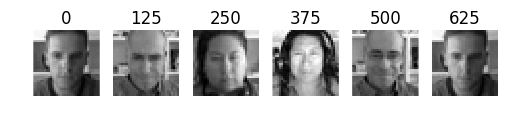

In [10]:
DM.display(start=0, end=625, step=125) # display the first fram of each video

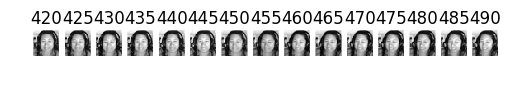

In [11]:
DM.display(start=420, end=490, step=5) # display every five frames

We also wrote a function that lets you see the progression of image differences, overlaid.
    * tau: monitors the memory of past images, the larger, the more you look in the past.
    * d: monitors the sensitivity to motion, the smaller, the most sensitive. 
The most recent motion is in red. The oldest is in blue.

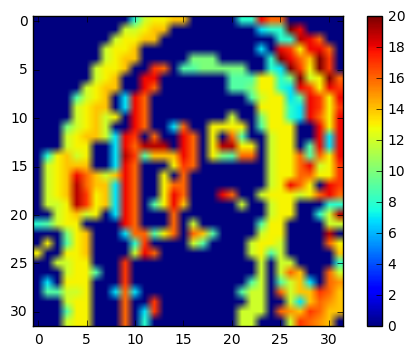

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,  16.,   0.,   0.],
       ..., 
       [  0.,   0.,   0., ...,  16.,  15.,  14.],
       [  0.,   0.,   0., ...,  16.,  14.,  14.],
       [  0.,   0.,   0., ...,  15.,  14.,   0.]])

In [12]:
DM.motion_history_image(start=420, end=490, step=5, tau=20, d=0.05) 

Practically, you have to predict 8 frames into the future.

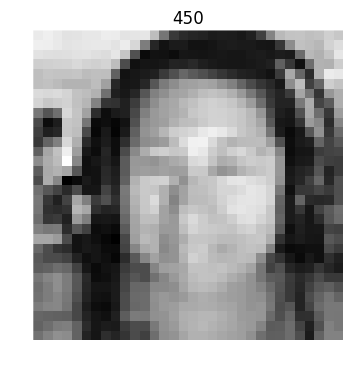

In [13]:
DM.display(start=450) 

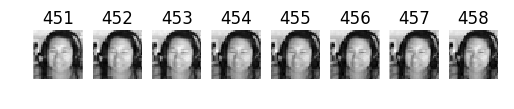

In [14]:
DM.display(start=451, end=458, step=1) 

The time index may be used to determine the cuts between videos. Note that the chunks of frames in "train" data are of size 125 and in "adapt" data, they follow the sequence:
101, 8, 8, 109, 8, 8, 109, 8, 8, 109, 8, 8, 109, etc. All videos have 125 frames. So there is a cut after the eighth frame in chunks of size 109.

Data Manager :: ========= Reading training data from ./sample_data/train
Data Manager :: ========= Reloading data from ./cache/DM.pickle
./cache/DM.pickle
[+] Success in  0.01 sec
[+] Success, loaded 0 videos in  0.01 sec


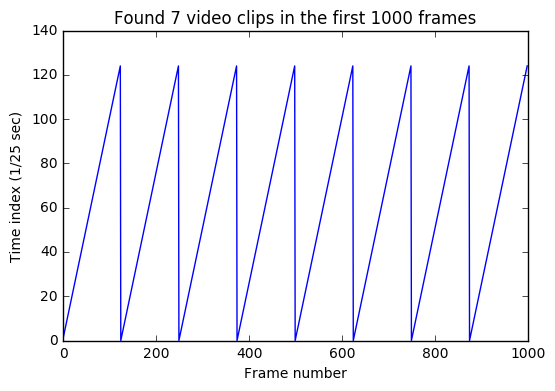

In [15]:
DM.loadTrainData(train_data_dir)
for i in range(10):
    DM.appendSamples(i, data_dir=adapt_data_dir) 
import matplotlib.pyplot as plt
fnum = min(len(DM.t), 1000)
plt.plot(DM.t[1:fnum])
plt.xlabel('Frame number')
plt.ylabel('Time index (1/25 sec)')
plt.title("Found %d video clips in the first %d frames" % (list(DM.t[1:fnum]).count(0), fnum))


# Train, Adapt, and Predict

Now you are ready to write your code. Use *model.py* as a template. It has three main functions, "train", "adapt", and "predict".

In [16]:
from model import Model
Model??

## Train
Load the entire training set and train:

In [17]:
M = Model(verbose=True) # No hyper-parameter here, this model just implements persistence :-)
DM.loadTrainData(train_data_dir)
M.train(DM.X, DM.t)

Version = Persitent
Data Manager :: ========= Reading training data from ./sample_data/train
Data Manager :: ========= Reloading data from ./cache/DM.pickle
./cache/DM.pickle
[+] Success in  0.00 sec
[+] Success, loaded 0 videos in  0.00 sec
Model :: ========= Training model =========
[+] Success, model trained in  0.00 sec


## Adapt
Add a few more frames and adapt:

In [18]:
DM.appendSamples(data_file="X0", data_dir=adapt_data_dir)
M.adapt(DM.X, DM.t) 

Model :: ========= Adapting model =========
[+] Success, model adapted in  0.00 sec


## Predict
Predict the next 8 frames:

In [19]:
    RESULT = DataManager()
    RESULT.X = M.predict(DM.X, num_predicted_frames=8)

Model :: ========= Making predictions =========
[+] Success, predictions made in  0.00 sec


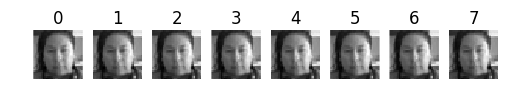

In [20]:
RESULT.display(start=0, end=7, step=1) 

# Compute your Accuracy
Prediction accuracy is computed using the RMSE. You can load the next chunk and see whether your predictions are accurate. On the server, when your code is tested, the next chunk is released only when you have made your predictions for the next 8 frames based on previously released data.

In [21]:
import numpy as np
from libscores import mse
DM.appendSamples(data_file="X1", data_dir=adapt_data_dir) # Get the next chunk
frame_num=8
solution = DM.X[-frame_num:].ravel()
prediction = RESULT.X.ravel()
print ("RMSE = %5.2f" % np.sqrt(mse(solution, prediction)))

RMSE =  0.01


## Understand the data organization
The expected sequence of query and answer videos will be:
<pre>
input name : number of frames    output name : number of frames

X0.h5 : 101 frames               Y0.h5   :   8 frames
X1.h5 : 8 frames                 Y1.h5   :   8 frames
X2.h5 : 8 frames                 Y2.h5   :   8 frames
X3.h5 : 109 frames               Y3.h5   :   8 frames
X4.h5 : 8 frames                 Y4.h5   :   8 frames
X5.h5 : 8 frames                 Y5.h5   :   8 frames
X6.h5 : 109 frames               Y6.h5   :   8 frames     
...
X599.h5 
</pre>

# Prepare your Submission

## Unit testing
It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code/</code> directory, then run this test to make sure everything works fine. The first argument is the "step", try at least two.

In [22]:
out_dir = os.path.join(root_dir, 'results')

In [23]:
!python predictSpatioTemporal.py 0 $data_dir $out_dir $root_dir


====> STEP: 0
Using input_dir: ./sample_data
Using output_dir: /Users/isabelleguyon/Documents/Projects/Challenges/See.4C/hackathon_bundle/zsee4C_starting_kit/results
Using code_dir: .
Using cache_dir: .
************************************************
******** Processing data chunk number 0 ********
************************************************
Data Manager :: Version = 1
Data Manager :: Version = 1
Version = Persitent
Data Manager :: ========= Reading training data from ./sample_data/train
['Xm1']
[+] Success, loaded 10 videos in  0.02 sec
Model :: ========= Training model =========
[+] Success, model trained in  0.00 sec
Model :: ========= Adapting model =========
[+] Success, model adapted in  0.00 sec
Model :: ========= Making predictions =========
[+] Success, predictions made in  0.00 sec
Data Manager :: ========= Saving data to /Users/isabelleguyon/Documents/Projects/Challenges/See.4C/hackathon_bundle/zsee4C_starting_kit/results/Y0.h5
[+] Success in  0.00 sec
[+] Done
[+] Ti

In [24]:
!python predictSpatioTemporal.py 1 $data_dir $out_dir $root_dir


====> STEP: 1
Using input_dir: ./sample_data
Using output_dir: /Users/isabelleguyon/Documents/Projects/Challenges/See.4C/hackathon_bundle/zsee4C_starting_kit/results
Using code_dir: .
Using cache_dir: .
************************************************
******** Processing data chunk number 1 ********
************************************************
Data Manager :: Version = 1
Data Manager :: Version = 1
Version = Persitent
Model :: ========= Adapting model =========
[+] Success, model adapted in  0.00 sec
Model :: ========= Making predictions =========
[+] Success, predictions made in  0.00 sec
Data Manager :: ========= Saving data to /Users/isabelleguyon/Documents/Projects/Challenges/See.4C/hackathon_bundle/zsee4C_starting_kit/results/Y1.h5
[+] Success in  0.00 sec
[+] Done
[+] Time spent  0.30 sec ::  Time budget 300.00 sec


## Making your Submission

Zip your code, including the <span style="color:red">sample_code/</span> directory, and the two scripts <span style="color:red">predictSpatioTemporal.py</span> and <span style="color:red">predict.sh</span>.

In [25]:
import datetime
from data_io import zip_submission
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
submission_filename = '../sample_submission_' + the_date + '.zip'
zip_submission(submission_filename, root_dir)
print("Submit the file: " + submission_filename)

Submit the file: ../sample_submission_17-02-09-21-39.zip
